## Basic example of use : primary block iteration with Parareal

We want to generate the graph for Parareal with space coarsening (restriction and prolongation frame the coarse solver). First, we need to import the relevant class from the code :

In [1]:
from blockops import BlockOperator, BlockIteration, I

Then define the different block operators, and provide a number of blocks :

In [2]:
nBlocks = 4

g = BlockOperator('G', cost=1)  # coarse solver
f = BlockOperator('F', cost=10)  # fine solver
r = BlockOperator('R', cost=0.2)  # restriction
p = BlockOperator('P', cost=0.2)  # prolongation (interpolation)

Additionnaly, we can provide some rules for our operators. For instance, we use prolongation and restriction operator such that interpolating a coarse field, then applying the restriction again does not modify the coarse field (happen when injection is used for restriction). We have to define the rule like this :

In [3]:
rules = [(r*p, I)]

Now we can define the block iteration of Parareal with space coarsening, that consists on an update formula :

$$u_{n+1}^{k+1} = (F - PGR) u_{n}^k + PGR u_{n}^{k+1},$$

the choice of a (fine) propagator, originally used for sequential integration of the initial value problem :

$$u_{n+1}^{seq} = F u_{n}^{seq},$$

a predictor used to initialize values for $k=0$ :

$$u_{n+1}^{0} = PGR u_{n}^{0}.$$

So we instanciate a `BlockIteration` object, providing the update formula, the propagator and the predictor as below.
Note that the update formula has to be a string, while the propagator and predictor arguments can be either a string (evaluated later) or directly a `BlockOperator` object. Finally, each block operators used in the string-like formula are given as `BlockOperator` variables in keyword arguments.

**Important** : the name of each `BlockOperator` variable must be the same as the variable names given in iteration formulas (but its variable name given as parameter can be different).

In [4]:
pararealSC = BlockIteration(
    "(f - p*g*r) u_{n}^k + p*g*r * u_{n}^{k+1}",  # block iteration update formula
    propagator=f, predictor="p*g*r",  # propagator and predictor
    rules=rules,  # list of rules (optional)
    f=f, p=p, g=g, r=r)  # definition of the block operator objects

Finally, we use the function `plotGraph` to generate the task graph of this block iteration. The task graph depends on the number of time steps `N`, and the number of required iterations per time point `K`. :

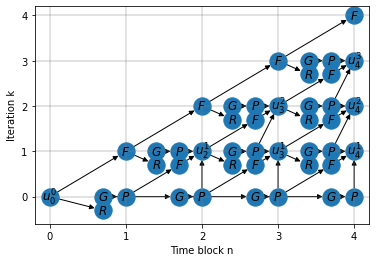

In [5]:
pararealSC.plotGraph(N=nBlocks, K=[1, 2, 3, 4])

Furthermore, we can use the function `speedup(N,K,nProc,schedule_type)` to obtain a theoretical minimum lower runtime bound and speedup compared to time stepping for this block iteration and given `N`, `K`, and the `'OPTIMAL'` scheduling strategy.

In [6]:
pararealSC.speedup(N=nBlocks, K=[1, 2, 2, 2], nProc=1000, schedule_type='OPTIMAL')

Block iteration: (f - p*g*r) u_{n}^k + p*g*r * u_{n}^{k+1}
Predictor: P*G*R (BlockOp)
N=4, K=[0, 1, 2, 2, 2] 

Runtime of schedule="Optimal" for nProc=1000: 22.799999999999997
Runtime time-stepping: 40 (This is currently not the correct value)
Speedup of schedule="Optimal" for nProc=1000: 1.75 

Theoretical lower runtime bound: 22.799999999999997
Theoretical maximum speedup compared to time stepping: 1.75 (This is currently not the correct value)


1.7543859649122808

**Info** : the iteration formula can use several times some the $u_{n}^{k}$ terms, that would work too :

In [7]:
pararealSC = BlockIteration(
    "f u_{n}^k + p*g*r * u_{n}^{k+1} - p*g*r u_{n}^{k}",
    propagator="f", predictor="p*g*r",
    **locals())

**Warning** : even if it makes things quite simple, the use of `locals()` can be dangerous, since all local variables are given in arguments, and some may be changed without knowing. To avoid such issues, it is recommended to give every `BlockOperator` variables used for the block iteration as named argument. For instance, the following instanciate the `BlockIteration` object undependant of any other variable predefined before :

In [8]:
pararealSC = BlockIteration(
    "f u_{n}^k + p*g*r * u_{n}^{k+1} - p*g*r u_{n}^{k}",
    propagator= "f", predictor="p*g*r", rules=[('r*p', I)],
    # propagator, predictor and rules should be given in string form, since the BlockOperator objects are not defined yet
    f=BlockOperator('F'), p=BlockOperator('P'), g=BlockOperator('G'), r=BlockOperator('R'))

Finally, the rules is given as named argument (default to `None`), and can be define either using string (evaluated later) or `BlockOperator` variables.

In particular, not using any rules here does don't allow to simplify predictor step :

In [9]:
pararealSC = BlockIteration(
    "f u_{n}^k + p*g*r * u_{n}^{k+1} - p*g*r u_{n}^{k}",
    propagator="f", predictor="p*g*r",
    f=BlockOperator('F'), p=BlockOperator('P'), g=BlockOperator('G'), r=BlockOperator('R'))
pararealSC.plotGraph(N=nBlocks, K=[0, 1, 2, 3, 4])

Exception: K must be a list of length N or an integer.